In [1]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 6
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
df = pd.read_excel(r'神经网络分类(RUN2).xlsx')
# df.head()

In [4]:
df.shape

(913, 124)

In [5]:
cloums = ['Time', 'FamilyMemberPatents', 'PatentHolders', 'Claims', 'Rank']
df = df[cloums]
# df

## 查看各样本数量

F:\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(<Axes: xlabel='Rank', ylabel='count'>,
 0    580
 1    182
 2    111
 3     40
 Name: Rank, dtype: int64)

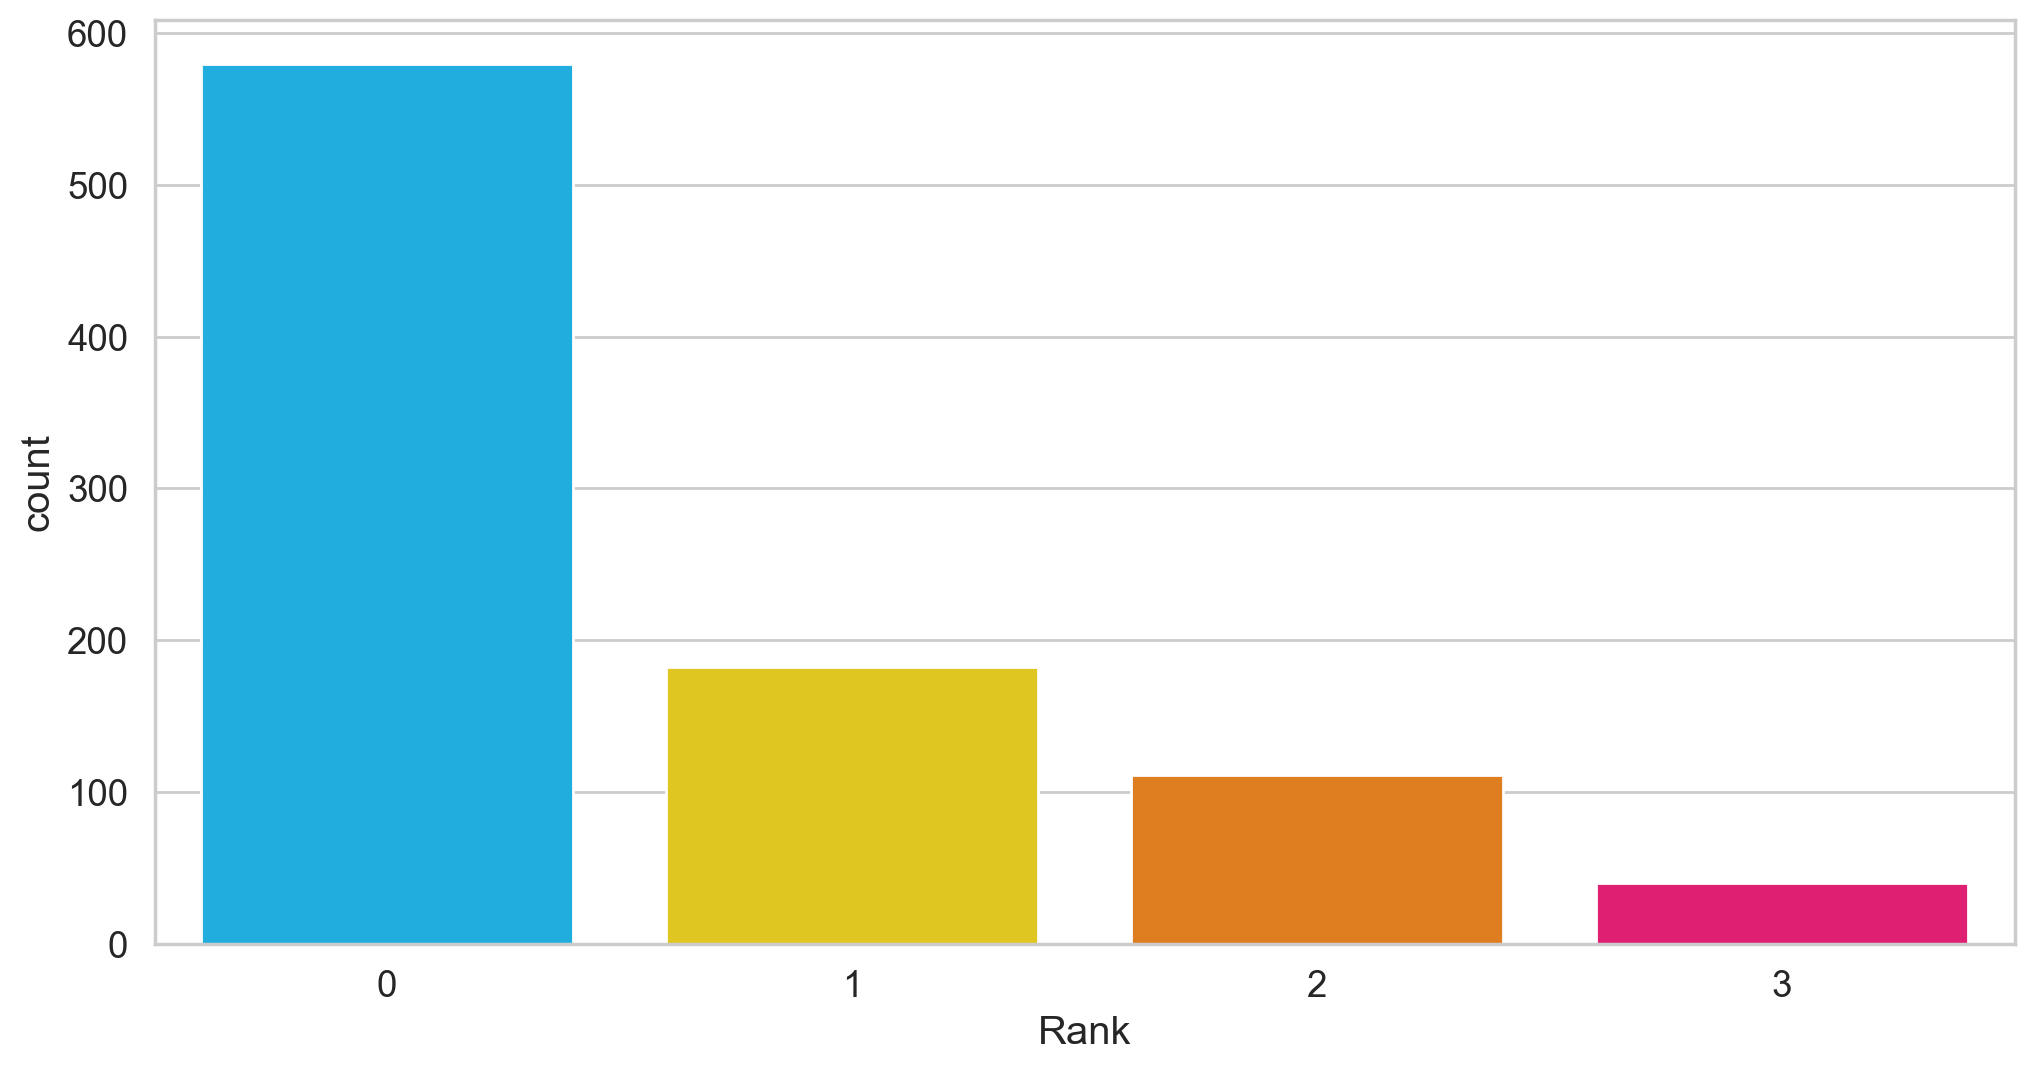

In [6]:
sns.countplot(df.Rank), df.Rank.value_counts()

In [7]:
df.Rank.value_counts() / df.shape[0]

0    0.635268
1    0.199343
2    0.121577
3    0.043812
Name: Rank, dtype: float64

# 特征工程 划分训练集、测试集

In [8]:
# 特征工程
X = df[['Time', 'PatentHolders','Claims', 'FamilyMemberPatents']].values
y = df[['Rank']].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [9]:
# 转换为PyTorch张量
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train.squeeze())  # 需要使用LongTensor并压缩维度
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test.squeeze())  # 需要使用LongTensor并压缩维度

In [10]:
#查看前五行数据
print(X_train[:5]) 
print(y_train[:5])

tensor([[5.5600e+02, 1.0000e+00, 0.0000e+00, 1.0000e+00],
        [6.8300e+02, 1.0000e+00, 1.0000e+00, 3.0000e+01],
        [2.0690e+03, 3.0000e+00, 8.0000e+00, 2.0000e+00],
        [1.0030e+03, 1.0000e+00, 8.0000e+00, 1.4000e+01],
        [7.6800e+02, 1.0000e+00, 8.0000e+00, 1.0000e+00]])
tensor([0, 3, 2, 3, 0])


# 构建模型
## 输入层、隐藏层、输出层
## 输入层是Bused   输出层是Rank 值：0 1 2 3
## 中间层两个

In [11]:
class Net(nn.Module):
    def __init__(self, n_feature, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_feature, 6)
        self.fc2 = nn.Linear(6, 5)
        self.fc3 = nn.Linear(5, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x     

In [12]:
# 初始化模型
n_features = X_train.shape[1]
num_classes = len(df['Rank'].unique())
net = Net(n_features, num_classes)

In [13]:
net.parameters

<bound method Module.parameters of Net(
  (fc1): Linear(in_features=4, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=4, bias=True)
)>

# 损失函数

In [14]:
criterion = nn.CrossEntropyLoss()

### 优化器

In [15]:
optimizer = optim.Adam(net.parameters(), lr=0.01)

# GPU计算

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  
X_train = X_train.to(device)
y_train = y_train.to(device)
  
X_test = X_test.to(device)
y_test = y_test.to(device)
  
net = net.to(device)
criterion = criterion.to(device)

## 训练

In [17]:
# 在训练循环中使用GPU
num_epochs = 10000
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    outputs = net(X_train.to(device))  # 将训练数据移到GPU
    loss = criterion(outputs, y_train.to(device))  # 将标签数据移到GPU
    loss.backward()
    optimizer.step()

    # 在每个epoch结束时，你可以打印训练和测试精确度
    if (epoch + 1) % 1000 == 0:
        net.eval()
        with torch.no_grad():
            train_outputs = net(X_train.to(device))
            train_predicted = torch.max(train_outputs, 1).indices
            train_accuracy = (train_predicted == y_train.to(device)).float().mean()

            test_outputs = net(X_test.to(device))
            test_predicted = torch.max(test_outputs, 1).indices
            test_accuracy = (test_predicted == y_test.to(device)).float().mean()

        print(f'Epoch [{epoch + 1}/{num_epochs}]')
        print(f'  train set - loss: {loss.item():.4f}, accuracy: {train_accuracy:.4f}')
        print(f'  test  set - loss: {criterion(test_outputs, y_test.to(device)).item():.4f}, accuracy: {test_accuracy:.4f}\n')

Epoch [1000/10000]
  train set - loss: 0.6348, accuracy: 0.7164
  test  set - loss: 0.7747, accuracy: 0.7104

Epoch [2000/10000]
  train set - loss: 0.5434, accuracy: 0.7740
  test  set - loss: 0.7415, accuracy: 0.7596

Epoch [3000/10000]
  train set - loss: 0.5393, accuracy: 0.7795
  test  set - loss: 0.7368, accuracy: 0.7541

Epoch [4000/10000]
  train set - loss: 0.5266, accuracy: 0.7877
  test  set - loss: 0.7106, accuracy: 0.7869

Epoch [5000/10000]
  train set - loss: 0.5217, accuracy: 0.7849
  test  set - loss: 0.6831, accuracy: 0.7705

Epoch [6000/10000]
  train set - loss: 0.5081, accuracy: 0.7932
  test  set - loss: 0.6850, accuracy: 0.7650

Epoch [7000/10000]
  train set - loss: 0.4950, accuracy: 0.7973
  test  set - loss: 0.6957, accuracy: 0.7814

Epoch [8000/10000]
  train set - loss: 0.4894, accuracy: 0.8014
  test  set - loss: 0.6792, accuracy: 0.7814

Epoch [9000/10000]
  train set - loss: 0.4932, accuracy: 0.7973
  test  set - loss: 0.6791, accuracy: 0.7596

Epoch [100

## 预测评估报告

In [18]:
# 在训练循环结束后，使用模型进行预测并生成评估报告
net.eval()
with torch.no_grad():
    train_outputs = net(X_train)
    train_predicted = torch.max(train_outputs, 1).indices
    test_outputs = net(X_test)
    test_predicted = torch.max(test_outputs, 1).indices

# 将预测结果从GPU转移到CPU
train_predicted = train_predicted.cpu().numpy()
test_predicted = test_predicted.cpu().numpy()
y_train = y_train.cpu().numpy()
y_test = y_test.cpu().numpy()

# 生成训练集和测试集的评估报告
from sklearn.metrics import classification_report

train_report = classification_report(y_train, train_predicted)
test_report = classification_report(y_test, test_predicted)

print("训练集分类报告：")
print(train_report)

print("\n测试集分类报告：")
print(test_report)

训练集分类报告：
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       466
           1       0.59      0.57      0.58       144
           2       0.57      0.45      0.50        86
           3       0.71      0.65      0.68        34

    accuracy                           0.80       730
   macro avg       0.69      0.66      0.67       730
weighted avg       0.79      0.80      0.80       730


测试集分类报告：
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       114
           1       0.58      0.50      0.54        38
           2       0.54      0.52      0.53        25
           3       0.29      0.33      0.31         6

    accuracy                           0.77       183
   macro avg       0.57      0.57      0.57       183
weighted avg       0.76      0.77      0.76       183



In [19]:
def RankAnalysis(Time, PatentHolders, Claims, FamilyMemberPatents):
    # 将输入值转换为PyTorch张量并移到GPU（如果模型在GPU上）
    input_tensor = torch.FloatTensor([Time, PatentHolders, Claims, FamilyMemberPatents])
    input_tensor = input_tensor.to(device)  # 如果之前指定了GPU设备

    # 使用模型进行预测
    net.eval()
    with torch.no_grad():
        prediction = net(input_tensor)

    # 获取预测的类别
    predicted_class = torch.argmax(prediction).item()

    # 输出预测结果
    print(f'输入参数: Time={Time}, PatentHolders={PatentHolders}, Claims={Claims}, FamilyMemberPatents={FamilyMemberPatents}')
    print(f'Rank: {predicted_class}')

In [20]:
RankAnalysis(1828, 1, 19, 29)

输入参数: Time=1828, PatentHolders=1, Claims=19, FamilyMemberPatents=29
Rank: 3
